# thal2 3:2 Bifurcation Diagrams

# Inits

## Imports

In [164]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import thal2 as t2

from lib.util import (get_phase, freq_est,follow_phase_diffs,follow_phase_diffs_del,
                        follow_phase_diffs_u,follow_phase_diffs_u_del,
get_smallest_eps,get_largest_eps, get_es_min, get_es_max)

from lib.rhs import _redu_c2,_full, _redu_full, _full, _full_mono_rhs

from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined, 
                            draw_quick_plot_f, add_diagram_1d_del_scatter)


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.signal import find_peaks
from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [165]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [166]:
pd1 = {'gL':0.05,'gna':3,'gk':5,
       'gt':5,'eL':-70,'ena':50,
       'ek':-90,'et':0,'esyn':0,
       'c':1,'alpha':3,'beta':2,
       'sigmat':0.8,'vt':-20,
       'ib':8.5,'del':0,'om':1,'om_fix':1}

In [167]:
# default period must be 2*np.pi
kws1 = {'var_names':['v','h','r','w'],
        'pardict':pd1,
        'rhs':t2.rhs,
        'coupling':t2.coupling,
        'init':np.array([-.64,0.71,0.25,0,6]),
        'TN':20000,
        'trunc_order':1,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':1}

## Defs

In [168]:
#### es_min,phi0 = get_es_min(data_bs_list,data_bu_list)
def get_monodromy_full(es_min,phi0,a,b,mname='',tol=1e-6,recompute=False):
    """
    es_min: minimum epsilon to use
    a: nmCoupling object
    b: het. parameter.
    mnamei are the model names to save the monodromy matrix and related calculations
    """    

    kw_b = {'a':a,'b':b,'recompute':recompute,'bifdir':'bif1d_thal2/','_full_rhs':_full}
    print('es_min,phi0',es_min,phi0)
    # the _u function has the ability to save and load Y values
    _,Y = follow_phase_diffs(**dict(phi0=phi0,eps_init=es_min,eps_final=es_min-.01,deps=-1),max_time=10000,tol=tol,return_point=True,**kw_b)

    print('Y',Y)
    # define parameters for finding monodromy of full system
    pd_vdp_thal = {**a.system1.pardict,**a.system2.pardict}
    pd_vdp_thal['b']=b
    pd_vdp_thal['a']=a
    
    pd_vdp_thal['eps']=es_min
    # print(pd1['del0'])
    
    # default period must be 2*np.pi
    kws_vdp_thal = {'var_names':['v0','h0','r0','w0','v1','h1','r1','w1'],
                    'pardict':pd_vdp_thal,
                    'rhs':_full_mono_rhs,
                    'coupling':lambda x: 0*x,
                    'init':Y, # from above
                    'use_init':True, # use init for direct LC calculation
                    'TN':50000,
                    'mode':'none', # forces not normalizing period.
                    'rtol_lc':1e-10,
                    'atol_lc':1e-10,
                    'trunc_order':0,
                    'z_forward':False,
                    'i_forward':False,
                    'i_bad_dx':[False,True,False,False,False,False],
                    'save_fig':False,
                    'max_iter':50,
                    'max_time_lc':5000,
                    'tol_root_lc':1e-8,
                    'halt_after_mono':True}

    m1 = rsp(idx='',model_name=mname,**kws_vdp_thal)

    return m1

In [169]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [170]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [171]:
ss,dss=np.linspace(0,2,100,retstep=True)

In [172]:
def compute_sol_all(a,eps,phi0,b,T=2000,dt=.01):
    """
    only for use in jupyter
    """
    t = np.arange(0,T,dt)
    args = {'args':(a,eps,b), 't_eval':t,**kw_sim}

    y0a = a.system1.lc['dat'][int((phi0/(2*np.pi)) * a.system1.TN),:]
    y0b = a.system2.lc['dat'][int((0/(2*np.pi)) * a.system2.TN),:]
    y0 = np.array([y0a,y0b]).flatten()
    #a.system1.pardict['del0'] = b

    tot = 0
    for i in range(len(a.het_coeffs)):
        tot += eps**i*b**(i+1)*a.het_coeffs[i]
    a.system1.pardict['del0'] = tot
    print(a.system1.pardict['del0'])
    #print(pd1['del0'])
    
    solf = solve_ivp(_full,[0,t[-1]], y0, **args)

    args['args'] = (a,eps,b,1)
    solr_o1 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    args['args'] = (a,eps,b,2)
    solr_o2 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,3)
    #solr_o3 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)
    
    #args['args'] = (a,eps,b,4)
    #solr_o4 = solve_ivp(_redu_c2,[0,t[-1]], [phi0],**args)

    return solf, solr_o1, solr_o2#, solr_o3, solr_o4


def load_sol_all(a,eps,phi0,b,T,dt=.01,path_loc='sols_temp/',recompute=True):
    if (not os.path.exists(path_loc)):
        os.makedirs(path_loc)
    
    fname_f = 'sol_f_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)
    fname_r = 'sol_r_thal2_nm={}{}_eps={}_b={}_T={}_phi0={}.dat'.format(a._n[1],a._m[1],eps,b,T,phi0)

    fname_f = path_loc + fname_f
    fname_r = path_loc + fname_r

    print('full',fname_f)
    print('redu',fname_r)
    
    file_dne = not(os.path.isfile(fname_f))
    file_dne += not(os.path.isfile(fname_r))

    if file_dne or recompute:
        solf, solr_o1, solr_o2 = compute_sol_all(a,eps,phi0,b,T=T,dt=dt)

        # phase of full model
        ta, pha = get_phase(solf.t,solf.y.T[:,:4], skipn=200,system1=a.system1)
        tb, phb = get_phase(solf.t,solf.y.T[:,4:], skipn=200,system1=a.system2)

        dat1 = np.zeros([len(ta),2])
        dat1[:,0] = ta
        dat1[:,1] = np.mod(pha - a.om*phb,2*np.pi)

        dat2 = np.zeros([len(solr_o1.t),5])
        dat2[:,0] = solr_o1.t
        dat2[:,1] = solr_o1.y[0]
        dat2[:,2] = solr_o2.y[0]

        np.savetxt(fname_f,dat1)
        np.savetxt(fname_r,dat2)

    else:
        dat1 = np.loadtxt(fname_f)
        dat2 = np.loadtxt(fname_r)
    return dat1, dat2

## Initialize Response Functions

In [173]:
system1 = rsp(idx=0,model_name='thal0_85_2k',**kws1)
system2 = rsp(idx=1,model_name='thal1_85_2k',**kws1)

mkdir ./data/thal0_85_2k/
* Computing LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Computing heterogeneous terms...
* Computing z...
dx=3.80e-10, al=9.09e-01                   
* Computing i...
dx=9.46e-12, al=9.09e-01                   
mkdir ./data/thal1_85_2k/
* Computing LC data...
self.T 6.283185307179586 omfix 0.990198152249508
self.T 6.283185307179586
loaded coupling expansions
* Loading monodromy...
* Floquet Exponent kappa = -0.02435447577890923
* Loading g symbolic...
* Computing g...
* Computing heterogeneous terms...
* Computing z...
dx=3.80e-10, al=9.09e-01                   
* Computing i...
dx=9.46e-12, al=9.09e-01                   


# Initialize Coupling 3:2

In [21]:
het_coeffs = [1,2000]

In [22]:
#recompute_list = ['k_thal0_85','k_thal1_85','h_thal0_85','h_thal1_85', 'h_data_thal0_85','h_data_thal1_85', 'p_data_thal0_85','p_data_thal1_85','p_thal0_85','p_thal1_85']
# recompute_list = ['k_thal0_85','k_thal1_85']
nm_tup = (3,2)
recompute_list = []
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',nm_tup[0]),'_m':('om1',nm_tup[1]),
         'NH':1024,'save_fig':False, 'recompute_list':recompute_list,
         'het_coeffs':het_coeffs, # [eps, eps^2, etc]
        }
a = nm.nmCoupling(**kw_nm)
nm_val = str(nm_tup[0])+str(nm_tup[1])

Initializing 32 Coupling...
pfactor 30
* Loading p symbolic...
* Loading p symbolic...
p order=0
p order=0
* Loading H symbolic...
* Loading H symbolic...
* Loading H thal0_85, order=0...
* Loading H thal1_85, order=0...
* Loading H thal0_85, order=1...
* Loading H thal1_85, order=1...


### Plot 1par eps

In [23]:
etup = (.001,.2,100)

<Axes: >

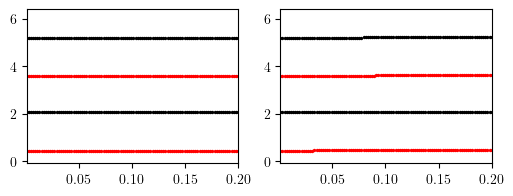

In [143]:
fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,b=0,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

### Plot 1par del

<Axes: >

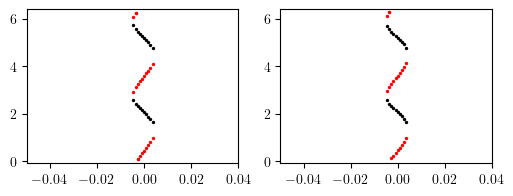

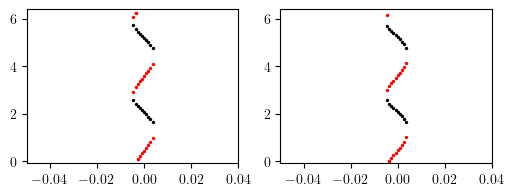

In [25]:
dtup12 = (-.05,.04,100)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.05,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

fig,axs = plt.subplots(1,2,figsize=(6,2))
kw_diagram = dict(a=a,eps=0.1,del_tup=dtup12,rhs=_redu_c2)
add_diagram_1d_del_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_del_scatter(axs[1],miter=2,**kw_diagram)

#for i in range(4):
#    draw_quick_plot_f(axs[i],data_b1_list,a)

## EPS VARY

In [26]:
kw_b = {'a':a,'b':0,'recompute':False,'bifdir':'bif1d_thal2/','_full_rhs':_full}
fname_bs = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_s.txt'
fname_bu = kw_b['bifdir']+'hyper_thal2_'+nm_val+'_b={}_u.txt'

In [27]:
mname_list = ['thal2_'+nm_val+'_b'+str(i)+'={}' for i in range(5)]

In [28]:
b_vals_full = []
e_vals_full = [] # save min eps values for all diagrams
e_hi_full = [] # save max eps values for all diagrams

## monodromy calculations
e_vals_mono_min = [] # save eps values at min monodromy
eigenvalues_min_all = []
b_min_all = []

e_vals_mono_max = [] # save eps values at max monodromy
eigenvalues_max_all = []
b_max_all = []

### b=0.004

#### Branches eps stable

In [131]:
b=.004
kw_b['recompute'] = False
kw_b['b'] = b

In [132]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=5,eps_init=0.1,eps_final=0,deps=-.01),
            dict(phi0=5,eps_init=0.099,eps_final=0.2,deps=.01)]

In [133]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5
phi init 5


In [134]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [144]:
kw_b['recompute'] = False

In [147]:
kw_b['b'] = 0
_,Yinit = follow_phase_diffs(c_sign=-1,**dict(phi0=4,eps_init=0.05,eps_final=0,deps=-2),max_iter=100,max_time=1000,return_point=True,**kw_b)

phi init 4
period_est 6.370063700637006 time_est 997.019970199702
iter, eps phase_diffs 0 0.05 [3.60817756 0.42686294]                    

data1 shape [[0.05       2.11960854 2.11960854 3.60817756 0.42686294]]


In [156]:
kw_b['b'] = b

In [158]:
_,Yinit2 = follow_phase_diffs_u(**dict(phi0=4,eps_init=0.0502,eps_final=0,deps=-2),use_point=Yinit,return_point=True,**kw_b)

phi init 4
phase_diffs_u_init=4_nm=32_b=0.004_ei=0.0502_ef=0_de=-2.txt
phase_diffs_u_pt_init=4_nm=32_b=0.004_ei=0.0502_ef=0_de=-2.txt
iter, eps phase_diffs 0 0.0502 [0.98423026 4.07700558]                   

phase diff [[0.98423026 4.07700558]]


In [159]:
in_dicts = [
    dict(phi0=3.9,eps_init=0.05,eps_final=0,deps=-.005),
    dict(phi0=3.9,eps_init=0.049,eps_final=0.2,deps=.005),
]

In [160]:
data_bu_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs_u(use_point=Yinit2,**in1,**kw_b)
    data_bu_list.append(dat)

phi init 3.9
phase_diffs_u_init=3.9_nm=32_b=0.004_ei=0.05_ef=0_de=-0.005.txt
phase_diffs_u_pt_init=3.9_nm=32_b=0.004_ei=0.05_ef=0_de=-0.005.txt
iter, eps phase_diffs 0 0.05 [0.9845712  4.07795604]                    
iter, eps phase_diffs 1 0.045000000000000005 [0.98803271 4.08600896]                
iter, eps phase_diffs 2 0.04000000000000001 [0.99165722 4.09451956]                
iter, eps phase_diffs 3 0.03500000000000001 [0.99604839 4.10348564]                
iter, eps phase_diffs 4 0.030000000000000013 [0.99982641 4.11243275]                
iter, eps phase_diffs 5 0.025000000000000015 [1.00359644 4.12136096]                
iter, eps phase_diffs 6 0.020000000000000018 [1.00735851 4.12966773]                
iter, eps phase_diffs 7 0.01500000000000002 [1.01128102 4.13902876]                
iter, eps phase_diffs 8 0.010000000000000023 [1.01502697 4.14669785]                
iter, eps phase_diffs 9 0.005000000000000025 [1.01849989 4.15588801]                

phase diff [[0.98457

In [161]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

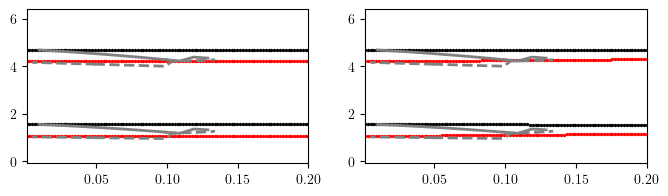

In [162]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [39]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.004

#### Branches eps stable

In [40]:
b=-.004
kw_b['recompute'] = False
kw_b['b'] = b

In [41]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=5.5,eps_init=0.1,eps_final=0,deps=-.005),
    dict(phi0=5.5,eps_init=0.099,eps_final=0.2,deps=.005)
]

In [42]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5.5
phi init 5.5


In [43]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [44]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [45]:
# _,Yinit = follow_phase_diffs_u(**dict(phi0=3.247159254137931,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [46]:
# in_dicts = [
#     dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.005),
#     dict(phi0=2,eps_init=0.099,eps_final=0.2,deps=.005),
# ]

In [47]:
data_bu_list = []
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [48]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

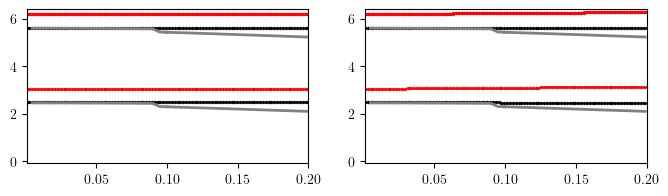

In [49]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [50]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(0)

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.0048

#### Branches eps stable

In [51]:
b=-.0048
kw_b['recompute'] = False
kw_b['b'] = b

In [62]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [
    dict(phi0=5.5,eps_init=0.2,eps_final=0,deps=-.005),
    dict(phi0=5.5,eps_init=0.199,eps_final=0.2,deps=.001)
]

In [63]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 5.5
phi init 5.5
period_est 6.010060100601007 time_est 996.959969599696
iter, eps phase_diffs 0 0.199 [2.65236674 5.8193344 ]                   
iter, eps phase_diffs 1 0.2 [2.64850914 5.81485519]                     

data1 shape [[0.199      2.00567475 2.00567475 2.65236674 5.8193344 ]
 [0.2        2.00527474 2.00527474 2.64850914 5.81485519]]


In [64]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [65]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [66]:
# _,Yinit = follow_phase_diffs_u(**dict(phi0=3.247159254137931,eps_init=0.1,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [67]:
# in_dicts = [
#     dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.005),
#     dict(phi0=2,eps_init=0.099,eps_final=0.2,deps=.005),
# ]

In [68]:
data_bu_list = []
# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs_u(use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [69]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

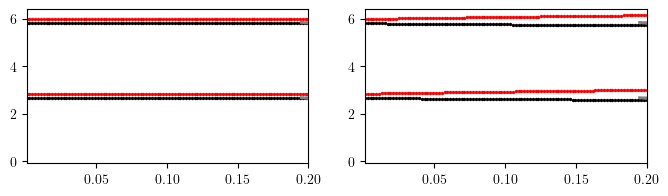

In [70]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

In [75]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.05

#### Branches eps stable

In [77]:
b=-.05
kw_b['recompute'] = False
kw_b['b'] = b

In [79]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.2,eps_final=0,deps=-.001),
            dict(phi0=2,eps_init=0.199,eps_final=0.2,deps=.001)]

In [80]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
period_est 6.030060300603007 time_est 997.449974499745
iter, eps phase_diffs 0 0.2 [5.04494355 2.00033294]                     
iter, eps phase_diffs 1 0.199 [5.07251412 2.02195644]                   
iter, eps phase_diffs 2 0.198 [5.10012214 2.04455338]                   
iter, eps phase_diffs 3 0.197 [5.12772648 2.06589615]                   
iter, eps phase_diffs 4 0.196 [5.15473907 2.08820936]                   
iter, eps phase_diffs 5 0.195 [5.18233521 2.11017117]                   
iter, eps phase_diffs 6 0.194 [5.2099633  2.13247628]                   
iter, eps phase_diffs 7 0.193 [5.23696054 2.15415158]                   
iter, eps phase_diffs 8 0.192 [5.26582828 2.17769846]                   
iter, eps phase_diffs 9 0.191 [5.2946575  2.20027158]                   
iter, eps phase_diffs 10 0.19 [5.32413991 2.22443516]                   
iter, eps phase_diffs 11 0.189 [5.35486671 2.24921906]                  
iter, eps phase_diffs 12 0.188 [5.38749231 2.27558941]    

In [82]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [83]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [84]:
# _,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [85]:
# in_dicts = [dict(phi0=2,eps_init=0.022,eps_final=0,deps=-.001),
#             dict(phi0=2,eps_init=0.021,eps_final=0.2,deps=.001),
#            ]

In [86]:
data_bu_list = []

# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(c_sign=-1,use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [87]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

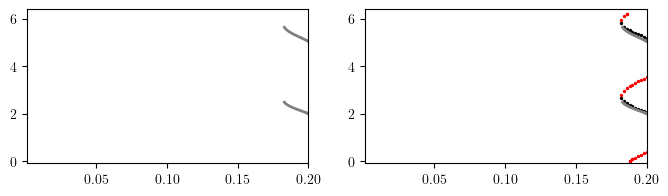

In [88]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [89]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# b_min_all.append(b)
# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [90]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.08

#### Branches eps stable

In [94]:
b=-.08
kw_b['recompute'] = False
kw_b['b'] = b

In [104]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.12,eps_final=0,deps=-.001),
            dict(phi0=2,eps_init=0.1199,eps_final=0.2,deps=.002)]

In [105]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
period_est 6.110061100611006 time_est 997.519975199752
iter, eps phase_diffs 0 0.12 [2.37881067 5.50560001]                    
iter, eps phase_diffs 1 0.119 [2.49181002 5.62877679]                   
iter=20, rel. err =1.01e-02                                              
data1 shape [[1.20000000e-01 2.03734154e+00 2.03734154e+00 2.37881067e+00 5.50560001e+00]
 [1.19000000e-01 2.03740821e+00 2.03740821e+00 2.49181002e+00 5.62877679e+00]
 [1.18000000e-01            nan            nan            nan            nan]
 [1.17000000e-01            nan            nan            nan            nan]
 [1.16000000e-01            nan            nan            nan            nan]
 [1.15000000e-01            nan            nan            nan            nan]
 [1.14000000e-01            nan            nan            nan            nan]
 [1.13000000e-01            nan            nan            nan            nan]
 [1.12000000e-01            nan            nan            nan            nan]


In [107]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [108]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [109]:
# _,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [110]:
# in_dicts = [dict(phi0=2,eps_init=0.022,eps_final=0,deps=-.001),
#             dict(phi0=2,eps_init=0.021,eps_final=0.2,deps=.001),
#            ]

In [111]:
data_bu_list = []

# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(c_sign=-1,use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [112]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

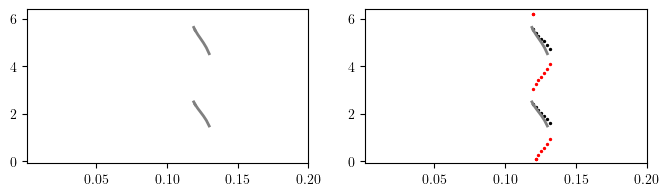

In [113]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [114]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# b_min_all.append(b)
# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [115]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

### b=-0.1

#### Branches eps stable

In [118]:
b=-.1
kw_b['recompute'] = False
kw_b['b'] = b

In [119]:
# in_dicts = [dict(phi0=phi0,eps_init=0.1,eps_final=0,deps=-.01) for phi0 in np.linspace(0,2*np.pi,20)]
in_dicts = [dict(phi0=2,eps_init=0.1,eps_final=0,deps=-.001),
            dict(phi0=2,eps_init=0.099,eps_final=0.2,deps=.002)]

In [120]:
data_bs_list = []
for i in range(len(in_dicts)):
    in1 = in_dicts[i]
    dat = follow_phase_diffs(**in1,**kw_b)
    data_bs_list.append(dat)

phi init 2
period_est 6.1500615006150054 time_est 996.4299642996431
iter, eps phase_diffs 0 0.1 [1.99489906 5.09291531]                     
iter, eps phase_diffs 1 0.099 [2.1100127 5.217233 ]                     
iter, eps phase_diffs 2 0.098 [5.18674799 2.06970702]                   
iter, eps phase_diffs 3 0.097 [5.30421876 2.17766352]                   
iter, eps phase_diffs 4 0.096 [5.4619582 2.3212862]                     
iter=5, rel. err =1.60e+01                                              
data1 shape [[1.00000000e-01 2.04747491e+00 2.04747491e+00 1.99489906e+00 5.09291531e+00]
 [9.90000000e-02 2.04734158e+00 2.04734158e+00 2.11001270e+00 5.21723300e+00]
 [9.80000000e-02 2.04734158e+00 2.04734158e+00 5.18674799e+00 2.06970702e+00]
 [9.70000000e-02 2.04740825e+00 2.04740825e+00 5.30421876e+00 2.17766352e+00]
 [9.60000000e-02 2.04740825e+00 2.04740825e+00 5.46195820e+00 2.32128620e+00]
 [9.50000000e-02            nan            nan            nan            nan]
 [9.40000000e-

In [121]:
# save hyperparameters
hyp_inputs = np.zeros([len(in_dicts),4])
for i in range(len(in_dicts)):
    hyp_inputs[i,0] = in_dicts[i]['phi0']
    hyp_inputs[i,1] = in_dicts[i]['eps_init']
    hyp_inputs[i,2] = in_dicts[i]['eps_final']
    hyp_inputs[i,3] = in_dicts[i]['deps']
np.savetxt(fname_bs.format(b),hyp_inputs)

#### Branches eps unstable

In [122]:
# kw_b['recompute'] = False
# kw_b['b'] = b

In [123]:
# _,Yinit = follow_phase_diffs_u(**dict(phi0=2,eps_init=0.02,eps_final=0,deps=-2),max_iter=100,return_point=True,**kw_b)

In [124]:
# in_dicts = [dict(phi0=2,eps_init=0.022,eps_final=0,deps=-.001),
#             dict(phi0=2,eps_init=0.021,eps_final=0.2,deps=.001),
#            ]

In [125]:
data_bu_list = []

# for i in range(len(in_dicts)):
#     in1 = in_dicts[i]
#     dat = follow_phase_diffs(c_sign=-1,use_point=Yinit,**in1,**kw_b)
#     data_bu_list.append(dat)

In [126]:
# # save hyperparameters
# hyp_inputs = np.zeros([len(in_dicts),4])
# for i in range(len(in_dicts)):
#     hyp_inputs[i,0] = in_dicts[i]['phi0']
#     hyp_inputs[i,1] = in_dicts[i]['eps_init']
#     hyp_inputs[i,2] = in_dicts[i]['eps_final']
#     hyp_inputs[i,3] = in_dicts[i]['deps']
# np.savetxt(fname_bu.format(b),hyp_inputs)

#### Plot combined 1 par

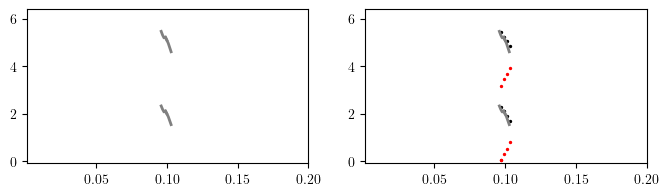

In [127]:
fig,axs = plt.subplots(1,2,figsize=(8,2))
kw_diagram = dict(a=a,b=b,eps_tup=etup,rhs=_redu_c2)
add_diagram_1d_scatter(axs[0],miter=1,**kw_diagram)
add_diagram_1d_scatter(axs[1],miter=2,**kw_diagram)

for i in range(2):
    draw_quick_plot_f(axs[i],data_bs_list,a)
    draw_quick_plot_f(axs[i],data_bu_list,a,ls='--')

#### Monodromys min

In [114]:
# # get min eps
# es_min,phi0 = get_es_min(data_bs_list,data_bu_list)


# eigenvalues_temp = []
# es_min_temp = []
# for i in range(5):
#     ee = es_min+0.0005*i
#     m1 = get_monodromy_full(ee,phi0[-1],a,b,mname=mname_list[i].format(b))
#     eigenvalues_temp.append(m1.eigenvalues)
#     es_min_temp.append(ee)

# b_min_all.append(b)
# eigenvalues_min_all.append(eigenvalues_temp)
# e_vals_mono_min.append(es_min_temp)
# #m1b = get_monodromy_full(es_min+.005,phi0[-1],a,b,mname=mname2.format(b))
# # m1c = get_monodromy_full(es_min+.02,phi0[-1],a,b,mname=mname3.format(b))
# #

# #print(m1.eigenvalues)
# #print(m1b.eigenvalues)

In [128]:
b_vals_full.append(b)

es = get_smallest_eps(data_bs_list)
eu = get_smallest_eps(data_bu_list)

e_vals_full.append(np.min([es,eu]))

es = get_largest_eps(data_bs_list)
eu = get_largest_eps(data_bu_list)

e_hi_full.append(np.max([es,eu]))

# Two parameter full

In [129]:
# fname_raw = 'thal2r_{}{}_2par_fixed.dat'
# data = np.loadtxt('../bifdat_2par/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_pos.dat'
data = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg.dat'
data2 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg2.dat'
data3 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

fname_raw = 'thal2_{}{}_o2_neg3.dat'
data4 = np.loadtxt('../v2_bifdat_2par/redu/'+fname_raw.format(a._n[1],a._m[1]))

(-0.1, 0.05)

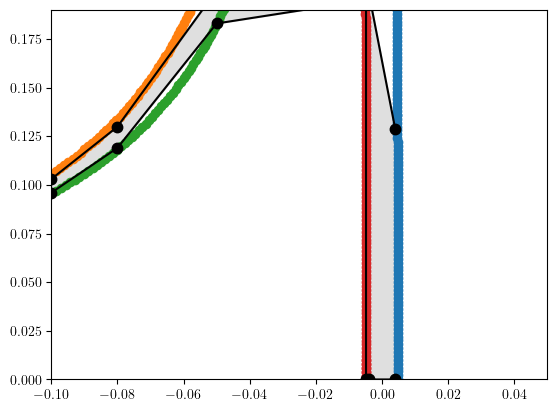

In [130]:
fig,axs = plt.subplots()
axs.fill_between(b_vals_full,e_vals_full,e_hi_full,color='gray',alpha=.25)
axs.plot(b_vals_full,e_vals_full,marker='.',color='k',markersize=15)
axs.plot(b_vals_full,e_hi_full,marker='.',color='k',markersize=15)

axs.scatter(data[:,1],data[:,0])
axs.scatter(data2[:,1],data2[:,0])
axs.scatter(data3[:,1],data3[:,0])
axs.scatter(data4[:,1],data4[:,0])

axs.set_ylim(0,.19)
axs.set_xlim(-.1,.05)

In [163]:
fname_lo = '../v2_bifdat_2par/full/thal2_2par_lo_{}{}.dat'.format(a._n[1],a._m[1])
fname_hi = '../v2_bifdat_2par/full/thal2_2par_hi_{}{}.dat'.format(a._n[1],a._m[1])

arr_lo = np.zeros([len(b_vals_full),2])
arr_hi = np.zeros([len(b_vals_full),2])

arr_lo[:,0] = b_vals_full
arr_lo[:,1] = e_vals_full

arr_hi[:,0] = b_vals_full
arr_hi[:,1] = e_hi_full

np.savetxt(fname_lo,arr_lo)
np.savetxt(fname_hi,arr_hi)

# Eigenvalue Convergence Plot

## Min

In [ ]:
fig,axs = plt.subplots(2,1)

eps_values = np.arange(0,+0.0005*5,.0005)
skipn = 2

for j in range(len(eigenvalues_min_all[::skipn])):
    nn = len(eigenvalues_min_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_min_all[::skipn][j][i])
        
        min1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[min1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    
    ee = e_vals_mono_min[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*+\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_thal2_min_{}{}.png'.format(a._n[1],a._m[1]))

## Max

In [ ]:
fig,axs = plt.subplots(2,1)

#es_min+.0001+0.0005*i
#ee = es_max-.0001-0.0005*i
eps_values = np.arange(-0.0001,0.0001-0.0005*5,-.0005)
skipn = 1

for j in range(len(eigenvalues_max_all[::skipn])):
    nn = len(eigenvalues_max_all[::skipn][j])

    at_eigen = []
    near_eigen = []
    
    for i in range(nn):
        eigenval = np.array(eigenvalues_max_all[::skipn][j][i])
        
        max1 = np.argsort(np.abs(eigenval-1))[:2]
        periodic1,bif1 = eigenval[max1]
        
        at_eigen.append(periodic1)
        near_eigen.append(bif1)

    ee = e_vals_mono_max[::skipn][j]
    e0 = ee[0]
    de = ee - e0
    
    axs[0].plot(eps_values,np.log(np.abs(1-np.array(near_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$, ' +r'$b='+str(b_min_all[j])+r'$')
    axs[1].plot(eps_values,np.log(np.abs(1-np.array(at_eigen))),label=r'$\varepsilon='+str(np.round(e0,3))+r'$')
    #axs[1].plot(lc_list2,label='Near Bifurcation')

    axs[0].legend()
    axs[1].legend()

    axs[0].set_xlabel(r'$\Delta\varepsilon$')
    axs[1].set_xlabel(r'$\Delta\varepsilon$')
    #axs[1].set_xlabel('Point')
    
    axs[0].set_ylabel(r'$\log(|1 - \lambda_{\varepsilon^*-\Delta\varepsilon}|)$')
    axs[1].set_ylabel(r'$\log(|1-\lambda_{Trivial}|)$')

    plt.tight_layout()
    plt.savefig('../figs/supp_convergence_vdp_thal_max_{}{}.png'.format(a._n[1],a._m[1]))